# Three Problem Solving Patterns From Leetcode

### Thomas Babinec

## 1. Overview

This document is a piece of Thomas Babinec's graduation from a data and algorithms bootcamp in 2021.  In particular, for the past few months the author has been solving ("grinding") problems on the popular coding platform Leetcode.com ("LC"). LC offers a database of ~2000 problems that have been compiled from interviews at technical companies and is therefore an awesome preperatory coding camp.  Users may track their progress over time solving problems with patterns that range from simple string and list sorting algorithms to more advanced topics such as breadth- and depth-first search (BFS/DFS), computational geometry, and so on. 

As of October 2021, the author has logged ~ 800 total problems (~450 "Easy", ~325 "Medium", and 10 "Hard") and is ranked ~7000 out of 1M+ Leetcoders.  On a personal node, it has been a strange, interesting, and emotional journey learning these CS fundamentals after an academic career in quantum, and the author is grateful to the folks at LC for offering this service.

This document has two purposes.  First, it is a tool to highlight a few the author's solutions and provide an example of technical writing and software documentation for applications.  Second, it may have some additional educational value for a novice to intermediate coder audience or to someone unfamiliar with LC or standard Markdown typesetting.     

Without further ado... in the following sections we cover three examples of code for algorithms / problem solving patterns from LC:

- **Kruskal's Algorithm for computing a minimum spanning tree.**  This example is excellent because it is a practical algorithm which combines data pre-processing, a key-ed sort of a list, and finally greedy selection of edges.
- **Breadth-First Search (BFS) of the Number of Islands of 1's in a Matrix of O's.**  This example is chosen because BFS is a ubiquitous tool for traversing trees and graphs, evaluating paths across these systems, etc.

- **SQL Query Featuring Window Function.** This is an example of querying a database for information that employs a window function, which is a tool for performing calculations of sets of rows in the database. It is a standard protocol.

We will first describe the problem (as given by Leetcode), then offer a solution, and show an example test case.


## 2. Kruskal's Algorithm for Computing a Minnimum Spanning Tree

**Problem Statement:** We are given an array of points that are coordinates of a 2D plane with points[i] = [x<sub>i</sub>, y<sub>i</sub>], as well as a cost (Manhattan distance) to connect them.  The Manhattan distance is given by |x<sub>i</sub>-x<sub>j</sub>| + |y<sub>i</sub>-y<sub>j</sub>| for two points [x<sub>i</sub>, y<sub>i</sub>] and [x<sub>j</sub>, y<sub>j</sub>].  The problem is to compute the minimum distance/cost to make all points connected with edges.  The number of points may range from 1 to 1000 and the value of the x, y coordinates may range from -1 million to + 1 million.

Below, we can see examples of a list of n points (in blue) populating the XY plane connected by n-1 weighted edges (in red).  On the left and in figure (A) we see a hypothetic example of some points which may represent nodes in a network, homes to be connected via electricity and water, etc.  In figure (B) we show an example of these points connected by a set of edges containing redundancy (e.g. closed loops).  Next, in figure (C) we see a set of connections that contains the minimal number of edges (N-1), but which is nevertheless sub-optimal because the edges have been chosen to maximize the distance of each connection.  Finally, on the far right and in figure (D) we see an optimal solution - a so called _Minimum Spanning Tree_ arrived at via Kruskal's algorithm. 

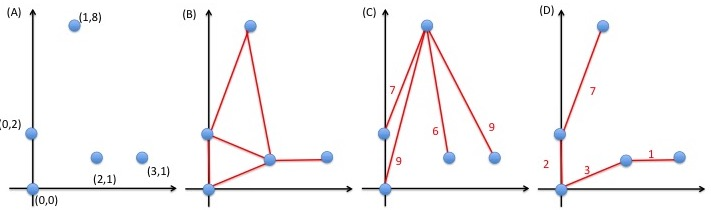

In [1]:
# List of [xi,yi] points for our example in figure (A):
points = [[0,0],[0,2],[2,1],[1,8],[3,1]]

Now, in order to arrive at the configuration in (D) we do some preprocessing of the raw points data re-express them in form which can be sorted.  From now on, we treat the pts in points as nodes 0, 1, ... n-1 and evaluate their pair-wise distances.  This generates a new list [n<sub>i</sub>, n<sub>j</sub>, w<sub>ij</sub>] that we call "graph" which captures nodes + (weighted) edges information.  The process is $O(pts^2)$ in both memory and time.

In [3]:
graph = []
n = len(points)

for ii in range(n-1):
    for jj in range(ii+1, n):
        manDist = abs(points[ii][0] - points[jj][0]) + abs(points[ii][1] - points[jj][1])
        graph.append([ii, jj, manDist])

The crucial next step is to sort this list by edge weight, which we perform below.  The complexity of the built-in python sorter is O(N<sub>pts</sub> log N<sub>pts</sub>) [1].

In [4]:
graphSorted = sorted(graph, key = lambda x: x[2])

# A list of [node i, node i, distance between nodes i and j]
print(graphSorted)

[[2, 4, 1], [0, 1, 2], [0, 2, 3], [1, 2, 3], [0, 4, 4], [1, 4, 4], [1, 3, 7], [2, 3, 8], [0, 3, 9], [3, 4, 9]]


We may now add edges of increasing length one-by-one until all nodes are connected.  At each step we consider whether adding the edge will results in a loop or cycles in the graph, in which case we pass adding the edge.  Thus, Kruskal's algorithm is a so-called "greedy" algorithm because at each step selection of edges to add is optimal.  This process is O(E log(V)), where E is the number of edges and V is the number of nodes [1].

In [5]:
# kruskal's algorithm (w/ set operations for union)

# hashtable is a set of key:value pairs with key nodes in the graph
# and value a set containing its connectivity:

hashtable = {el:{el} for el in range(n)}
        
count, totalDist = 0, 0
while count < n-1:
    for edge in graphSorted:
        
        # adding an edge that generates a closed cycle is extraneous
        # and we do not add it to the Minimum Spanning Tree:
        if edge[1] in hashtable[edge[0]]:
            pass
                
        # otherwise add the edge:
        else:
            uniques = hashtable[edge[0]].union(hashtable[edge[1]])
            for el in uniques:
                hashtable[el] = uniques
            
            totalDist += edge[2]
            count += 1

As we can see next, the length (totalDist) of this minimum spanning tree in figure (D) is 13.

In [10]:
print(totalDist)

13


## 3. Number of Islands and Breadth-First Search (BFS)

**Problem Statement:** We are given an m x n matrix of 0's and 1's.  Our goal is to count the number of "islands" of 1's embedded inside this matrix.  m and n are chosen to each range from one to several hundred.

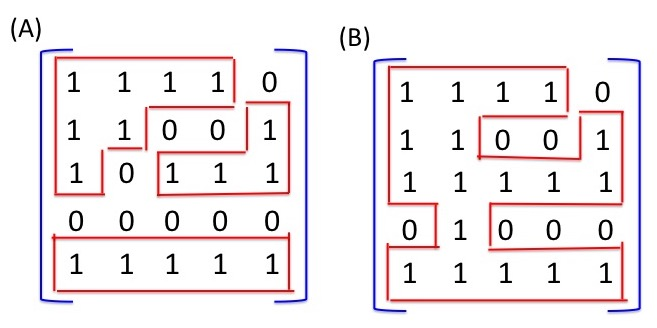

Above we see two examples of a 5x5 matrix of 0's and 1's as given by the problem statement.  On the left and in figure (A), we see highlighted in red three regions/islands.  On the right, and in figure (B), we have modified two critical elements of the matrix so that the number of islands is reduced to just one.  While this appears easy to see by eye, implementation of an algorithm to perform this calculation is slightly tricky and requires a bit of finesse.  

First, we start with the easy part by extracting the dimensions m and n:

In [20]:
gridA = [[1,1,1,1,0],[1,1,0,0,1],[1,0,1,1,1],[0,0,0,0,0],[1,1,1,1,1]]
gridB = [[1,1,1,1,0],[1,1,0,0,1],[1,1,1,1,1],[0,1,0,0,0],[1,1,1,1,1]]

m, n = len(gridA), len(gridA[0])

Now, we perform breadth-first search (BFS) on the grid.  We do this by scanning through all m x n elemnts of grid.  While scanning, if we arrive at a new island (an index where grid[row][column]=1) then we append this [row, column] combination to a queue, which is a data structure where insertion of new elements (enqueing) occurs at the top and deletion (dequeing) from the bottom.  

We then scan 4- directionally from this base element of the queue in search of new territory.  If new 1's are identified then those positions in the matrix are added to queue. After that, we consider the first element of the queue checked, queue it. and repeat the process with the new bottom element.  

A critical trick is to reset each 1 value in the grid to a 0 once we have identified it as a part of an island, which prevents double-counting.  Also, we must check that the elements coupled 4-directionally are within the bounds 0 <= row <= m-1 and 0 <= column <= n-1.

In [23]:
num_islands = 0

# select gridA or gridB
grid = gridA

# the loop through the m x n array:
for ii in range(m):
    for jj in range(n):
                
        # criteria for a new island:
        if grid[ii][jj] == 1:
            # mark the element as "checked" by changing its value to '0':
            grid[ii][jj] == 0
                    
            num_islands += 1
            queue = [[ii,jj]]
                    
            # BFS for identifying all territory associated with this 
            # island and then labeling it as "checked" by reseting value
            # to equal 0: 
            while len(queue) > 0:        
                row, col = queue[0]
                    
                if row-1 >= 0:
                    if grid[row-1][col] == 1:
                        queue.append([row-1, col])
                        grid[row-1][col] = 0
            
                if row+1 <= m-1:
                    if grid[row+1][col] == 1:
                        queue.append([row+1, col])
                        grid[row+1][col] = 0
                                           
                if col-1 >= 0:
                    if grid[row][col-1] == 1:
                        queue.append([row,col-1])
                        grid[row][col-1] = 0
                            
                if col+1 <= n-1: 
                    if grid[row][col+1] == 1:
                        queue.append([row,col+1])
                        grid[row][col+1] = 0
                        
                # pop the first element at the end of each BFS loop:
                queue.pop(0)

As we can see below, the number of islands for gridA is equal to 3.  If grid is changed to gridB then the result gives 1 as expected.  

The complexity of this calculation is O(m*n) for time and O(n) in memory.

In [24]:
print(num_islands)

3


### 4. SQL Query Featuring Window Function

**Problem Statement:** We are given a table _Sales_ containing columns sale_id, product_id, year, quantity, and price.  Write an SQL query that selects product id, year, quantiy, and the first year each product is sold.

We conclude with a short and sweet example of database querying with Structured Query Language (SQL).  However, for simplicity's sake we not be e.g. connecting to a SQL database via SQLalchemy and will limit the discussion to what can be inputted manually here.   

We are asked to re-organize the following table so that we keep only the rows corresponding to the first year a particular product_id is sold.  We do this in a two-step process.

|sale_id|product_id|year|quantity|price|
-------|----------|----|--------|-----
|1|100|2008|10|5000|
|2|100|2009|12|5000|
|3|200|2011|15|9000|
|4|300|2007|12|1000|
|5|300|2008|14|1000|
|6|300|20011|15|1000|


We first write a subquery with window function which divides ("partitions") the rows according to product_id, and then orders and ranks the rows by year.  The corresponding SQL query looks like:

and gives a table subq that looks like:

|sale_id|product_id|year|quantity|price|rk|
-------|----------|----|--------|-----|---
|1|100|2008|10|5000|1|
|2|100|2009|12|5000|2|
|3|200|2011|15|9000|1|
|4|300|2007|12|1000|1|
|5|300|2008|14|1000|2|
|6|300|20011|15|1000|3|

We may follow up with a query such as the following to isolate rows where the column rk is equal to one:

to arrive at our desired result:

|product_id|year|quantity|price|
-----------|----|--------|-----
|100|2008|10|5000|
|200|2011|15|9000|
|300|2007|12|1000|


## 5. References

[0] www.leetcode.com

[1] www.stackoverflow.com

[2] Gayle Laakmann McDowell, "Cracking the Coding Interview, 6th Edition", CareerCup (2020).